In [1]:
import os
from collections import defaultdict

import torch
from peft import PeftModel

from transformers import AutoModelForCausalLM

In [2]:
def load_model(model_name):
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16)
    model.eval()
    return model

In [3]:
# Load the finetuned model from Hugging face or local disk
model_name = "meta-llama/Llama-2-7b-hf" #"mistralai/Mistral-7B-Instruct-v0.2"
peft_name = "trl/output/checkpoint-100"
model = load_model(model_name)
peft_model = PeftModel.from_pretrained(model, peft_name).to("cuda:1")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
for i in peft_model.model.model.layers:
    print(i.self_attn.q_proj.base_layer.weight.shape)
    print(i.self_attn.q_proj.lora_A.default.weight.shape)
    print(i.self_attn.q_proj.lora_B.default.weight.shape)
    break

torch.Size([4096, 4096])
torch.Size([64, 4096])
torch.Size([4096, 64])


In [101]:
def merged_lora_weights(layer):
    alpha = 2 * layer.lora_A.default.weight.shape[0]
    lora_weights = layer.lora_A.default.weight.T @ layer.lora_B.default.weight.T
    combined_weights = layer.base_layer.weight + alpha*lora_weights
    return combined_weights


def get_model_weights(model, tag=None):
    query_weights = []
    for layer in model.model.model.layers:
        if tag == "lora":
            query_weights.append(merged_lora_weights(layer.self_attn.q_proj))
        else:
            query_weights.append(layer.self_attn.q_proj.base_layer.weight)
    return query_weights


def weight_decomposition(weights, store: dict, tag=None):
    for i in range(len(weights)):
        if tag == "dora":
            magnitude = weights[i][0]
            direction = weights[i][1]
        else:
            magnitude = weights[i].norm(p=2, dim=1, keepdim=True)
            direction = weights[i] / magnitude
        store[f"query_layer_{i}"].append(magnitude)
        store[f"query_layer_{i}"].append(direction)


def delta_magnitude(pt_weights, ft_weights):
    layer_wise_delta_m = {}
    for i in range(0, 32, 6):
        a = ft_weights.get(f"query_layer_{i}")[0]
        b = pt_weights.get(f"query_layer_{i}")[0]
        k = b.shape[0]
        d_m = torch.sum(abs(a - b)) / k
        layer_wise_delta_m[f"layer_{i}"] = round(d_m.item(), 6)
    return layer_wise_delta_m


def delta_direction(pt_weights, ft_weights):
    layer_wise_delta_d = {}
    for i in range(0, 32, 6):
        a = ft_weights.get(f"query_layer_{i}")[1]
        b = pt_weights.get(f"query_layer_{i}")[1]
        k = b.shape[0]
        sim = torch.nn.functional.cosine_similarity(a.t(), b.t(), dim=1)
        d_m = torch.sum(1 - sim) / k
        layer_wise_delta_d[f"layer_{i}"] = round(d_m.item(), 6)
    return layer_wise_delta_d

In [102]:
pretrained_weight_decomposition = defaultdict(list)
pretrained_query_weights = get_model_weights(peft_model)
weight_decomposition(pretrained_query_weights, pretrained_weight_decomposition)

In [103]:
def get_magnitude_directions(tag):
    checkpoint_path = "trl/output"
    artifacts = os.listdir(checkpoint_path)
    combined_dm, combined_dd = defaultdict(list), defaultdict(list)

    for model_dir in artifacts:
        if not model_dir.startswith("."):
            decomposed_weights = defaultdict(list)
            model_path = os.path.join(checkpoint_path, model_dir)
            new_model = PeftModel.from_pretrained(model, model_path).to("cuda:1")
            query_weights = get_model_weights(new_model, tag=tag)
            del new_model

            weight_decomposition(query_weights, decomposed_weights, tag=tag)
            dm = delta_magnitude(pretrained_weight_decomposition, decomposed_weights)
            dd = delta_direction(pretrained_weight_decomposition, decomposed_weights)

            name = model_dir[-3:]
            combined_dm[name].append(dm)
            combined_dd[name].append(dd)
    return combined_dm, combined_dd

In [104]:
tag = "lora"
lora_m, lora_d = get_magnitude_directions(tag=tag)

In [105]:
# Accumulate magnitude and direction of each checkpoint layer wise for plotting
ckpt_wise_m_d = []
for model_name in ['200', '400', '600', '700', 'nal']:
    if model_name in lora_m and model_name in lora_d:
        magnitude, direction = lora_m[model_name], lora_d[model_name]
        k = 0
        layer_wise_m_d = {}
        for m, d in zip(magnitude[0].items(), direction[0].items()):
            layer_wise_m_d[f"layer_{k}"] = {"m": m[1], "d": d[1]}
            k += 1
        ckpt_wise_m_d.append(layer_wise_m_d)

In [106]:
ckpt_wise_m_d

[{'layer_0': {'m': 10.609375, 'd': 0.878906},
  'layer_1': {'m': 2.722656, 'd': 0.585449},
  'layer_2': {'m': 2.703125, 'd': 0.598633},
  'layer_3': {'m': 3.617188, 'd': 0.608398},
  'layer_4': {'m': 3.923828, 'd': 0.658203},
  'layer_5': {'m': 2.740234, 'd': 0.58252}},
 {'layer_0': {'m': 11.671875, 'd': 0.888184},
  'layer_1': {'m': 4.792969, 'd': 0.710449},
  'layer_2': {'m': 4.945312, 'd': 0.722656},
  'layer_3': {'m': 5.296875, 'd': 0.706543},
  'layer_4': {'m': 6.191406, 'd': 0.762207},
  'layer_5': {'m': 4.628906, 'd': 0.708984}},
 {'layer_0': {'m': 11.945312, 'd': 0.887695},
  'layer_1': {'m': 5.195312, 'd': 0.726074},
  'layer_2': {'m': 5.347656, 'd': 0.738281},
  'layer_3': {'m': 5.667969, 'd': 0.723145},
  'layer_4': {'m': 6.554688, 'd': 0.771973},
  'layer_5': {'m': 5.847656, 'd': 0.760742}},
 {'layer_0': {'m': 11.921875, 'd': 0.888184},
  'layer_1': {'m': 5.203125, 'd': 0.726074},
  'layer_2': {'m': 5.355469, 'd': 0.73877},
  'layer_3': {'m': 5.6875, 'd': 0.724121},
  'laye

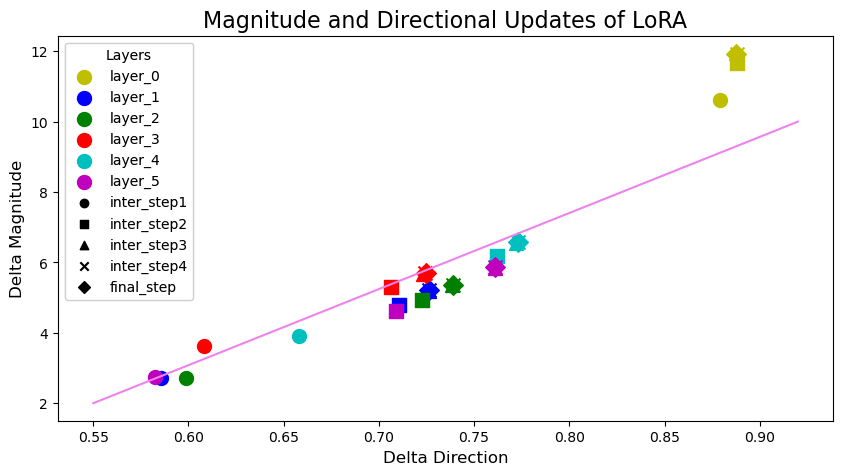

In [109]:
import matplotlib.pyplot as plt
import numpy as np

layers = ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5']
markers = ['o', 's', '^', 'x', 'D']
colors = ['y', 'b', 'g', 'r', 'c', 'm']
marker_labels = ["inter_step1",  "inter_step2", "inter_step3", "inter_step4", "final_step"]

plt.figure(figsize=(10, 5))

for i, layer in enumerate(layers):
    for j, entry in enumerate(ckpt_wise_m_d):
        plt.scatter(entry[layer]['d'], entry[layer]['m'], color=colors[i], label=layer if j == 0 else "", marker=markers[j], s=100)

for i, marker in enumerate(markers):
    plt.scatter([], [], marker=marker, color='k', label=marker_labels[i])

x = np.linspace(0.55, 0.92, 100)
y = np.linspace(2, 10, 100)
plt.plot(x, y, '-', color='violet')

legend_layers = plt.legend(title='Layers', loc='upper left')
plt.gca().add_artist(legend_layers)

plt.xlabel('Delta Direction', fontsize=12)
plt.ylabel('Delta Magnitude', fontsize=12)
plt.title('Magnitude and Directional Updates of LoRA', fontsize=16)
plt.grid(False)

plt.savefig('plot_lora_q_proj.jpg', format='jpg')
plt.show()